# Model Training For Credit Scoring Models

# Packages

### Packages required

In [0]:
  !pip install shap

In [0]:
import pandas as pd
import numpy as np

from imblearn.over_sampling import SMOTE
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import itertools    
from itertools import compress

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

import xgboost as xgb
from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, Nadam, rmsprop, SGD
from keras.losses import binary_crossentropy, hinge
from keras.wrappers.scikit_learn import KerasClassifier
from keras.activations import relu, elu, softmax, sigmoid

from mlxtend.evaluate import mcnemar_table
from mlxtend.evaluate import mcnemar
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sys as sys
sys.setrecursionlimit(1500)

import warnings
warnings.filterwarnings('ignore')

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files

In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Train/Test Split and Class Balancing Functions


### Train/Test Split Function

In [0]:
def get_train_test_split(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return  np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

### Class Balancing Function

In [0]:
def balance_classes(X, y):
    sm = SMOTE(random_state=2)
    X_train_res, y_train_res = sm.fit_sample(X, y.ravel())
    return X_train_res, y_train_res

In [0]:
def set_sets(X,y):
    X_train, X_test, y_train, y_test =  get_train_test_split(X,y)
    X_train_res, y_train_res = balance_classes(X_train, y_train)
    print("Number rows X_train dataset: ", X_train.shape)
    print("Number rows y_train dataset: ", y_train.shape, "\n")
    print("Number rows X_test dataset: ", X_test.shape)
    print("Number rows y_test dataset: ", y_test.shape, "\n")
    print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
    print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))
    print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
    print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
    print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
    print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))
    return X_train_res, X_test, y_train_res, y_test

# Read in Data and Use Functions to Select and Balance Data

### Seperate Data into Different Socio-demographic, Credit Bureau and Alternative

In [0]:
def seperate_data(data, types):
    cols = []
    for t in types:
        cols = cols + t
    data = data[cols]
    return data
  
def get_features(types):
    cols = []
    for t in types:
        cols = cols + t
    return cols

In [0]:
    socio = ['property_status','highest_education','time_at_employer','loan_purpose',
             'time_at_current_address', 'state', 'bank', 'marital_status', 'employment_status',
             'gender', 'device_brand','sector','application_time', 'application_week','income',
             'time_at_property', 'num_applications', 'age'
    ]
    
    credit = ['total_accounts', 'open_accounts_by_date', 'closed_accounts_by_date','performing_loans',
              'paid_loans', 'nonperforming_loans', 'lost_loans', 'missed_payments'
    ]
    
    alt = ['competitor_count', 'banking_count', 'news_count', 'gambling_count', 'vpn_count',
           'app_count', 'device_price', 'max_balance', 'min_balance', 'credit_transactions',
           'max_credit', 'min_credit', 'debit_transactions', 'max_debit', 'min_debit', 
           'insufficient_funds','succesful_payments', 'max_succesful_loan_payment', 'min_succesful_loan_payment',
           'unsuccesful_payments', 'max_unsuccesful_loan_payment', 'min_unsuccesful_loan_payment',
           'rejected_loans', 'max_loan_amount'
    ]

### Reading Data from Google Drive

In [0]:
# read in
data_link = drive.CreateFile({'id':'1uSH8hGWPAacgmZocXjh0uwNrXRj1yfdC'}) 
data_link.GetContentFile('final_model_data.csv')
data = pd.read_csv('final_model_data.csv')
data = data.drop(['Unnamed: 0', 'check'], axis=1)

# select
# data = data.iloc[:1000, :]
target = data['defaulted']
data = seperate_data(data, [socio,credit,alt])
data.head()

,property_status,highest_education,time_at_employer,loan_purpose,time_at_current_address,state,bank,marital_status,employment_status,gender,device_brand,sector,application_time,application_week,income,time_at_property,num_applications,age,total_accounts,open_accounts_by_date,closed_accounts_by_date,performing_loans,paid_loans,nonperforming_loans,lost_loans,missed_payments,competitor_count,banking_count,news_count,gambling_count,vpn_count,app_count,device_price,max_balance,min_balance,credit_transactions,max_credit,min_credit,debit_transactions,max_debit,min_debit,insufficient_funds,succesful_payments,max_succesful_loan_payment,min_succesful_loan_payment,unsuccesful_payments,max_unsuccesful_loan_payment,min_unsuccesful_loan_payment,rejected_loans,max_loan_amount
0,0.806746,0.489892,0.812519,0.000000,0.780568,0.711475,0.485242,0.000000,0.790843,0.0,0.222567,0.764172,0.646574,0.000000,7.500000e-08,0.193656,0.006579,0.027397,0.021053,0.026667,0.013158,0.010417,0.0,0.125,0.076923,0.073801,0.428571,0.043478,0.0,0.000000,0.047619,0.092601,0.001204,0.000271,0.987892,0.000000,0.000070,0.719049,0.000316,0.000006,0.921367,0.000000,0.00027,1.188119e-14,1.188119e-14,0.002273,2.524861e-09,2.524861e-09,0.000000,0.723878
1,0.917729,0.407932,0.327400,0.999145,0.582878,0.664383,0.642608,0.000000,0.790843,0.0,0.222567,0.764172,0.561708,1.000000,2.500000e-08,0.055092,0.072368,0.011986,0.010526,0.013333,0.013158,0.020833,0.0,0.000,0.000000,0.003690,0.285714,0.086957,0.0,0.027778,0.000000,0.088062,0.001745,0.000273,0.987892,0.000607,0.000010,0.755124,0.000842,0.000022,0.921367,0.000000,0.00000,0.000000e+00,0.000000e+00,0.009091,5.049709e-09,0.000000e+00,0.000000,0.723886
2,0.917729,0.489892,0.620556,0.234357,0.409101,0.655875,0.625619,0.184296,1.000000,0.0,0.000000,0.656833,0.561708,0.505533,7.500000e-08,0.126878,0.000000,0.042808,0.021053,0.000000,0.039474,0.031250,0.0,0.000,0.000000,0.011070,0.428571,0.043478,0.0,0.000000,0.000000,0.052202,0.000664,0.000282,0.987892,0.003113,0.000015,0.755097,0.002211,0.000079,0.921367,0.000000,0.00081,1.000000e+00,9.900990e-16,0.000000,2.524854e-09,2.524854e-09,0.000000,0.723916
3,0.917729,0.489892,0.620556,1.000000,0.527291,0.689317,0.625619,0.274025,0.790843,0.0,0.125700,0.764172,1.000000,0.000000,4.450000e-07,0.068447,0.000000,0.063356,0.063158,0.000000,0.092105,0.062500,0.0,0.125,0.000000,0.044280,0.428571,0.043478,0.0,0.000000,0.000000,0.049024,0.002547,0.000294,0.987810,0.002809,0.000020,0.755124,0.003229,0.000084,0.921366,0.000000,0.00054,1.000000e+00,1.000000e+00,0.000000,2.524854e-09,2.524854e-09,0.000000,0.723902
4,0.772470,0.489892,1.000000,0.000000,0.215375,0.711475,0.521283,0.000000,1.000000,0.0,0.125700,0.737627,0.646574,1.000000,7.500000e-08,0.375626,0.052632,0.006849,0.021053,0.000000,0.039474,0.031250,0.0,0.000,0.000000,0.003690,0.142857,0.130435,0.0,0.013889,0.000000,0.062642,0.000530,0.000272,0.987891,0.000911,0.000011,0.755098,0.000579,0.000014,0.921367,0.004545,0.00135,1.287129e-14,1.287129e-14,0.006818,2.524862e-09,2.524859e-09,0.060976,0.723879


In [0]:
# balance classes
X_train_res, X_test, y_train_res, y_test = set_sets(data, target)

Number rows X_train dataset:  (48539, 50)
Number rows y_train dataset:  (48539,) 

Number rows X_test dataset:  (12135, 50)
Number rows y_test dataset:  (12135,) 

Before OverSampling, counts of label '1': 10147
Before OverSampling, counts of label '0': 38392 

After OverSampling, the shape of train_X: (76784, 50)
After OverSampling, the shape of train_y: (76784,) 

After OverSampling, counts of label '1': 38392
After OverSampling, counts of label '0': 38392


# Feautre Selection

### Correlation

In [0]:
# def get_feat_corr(X):
#     plt.figure(figsize=(10,10))
#     X = pd.DataFrame(X, columns=data.columns)
#     cor = X.corr().round(decimals=2)
#     sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
#     plt.show()

In [0]:
# get_feat_corr(X_train_res)

### Feature Seleciton

In [0]:
def feature_selection(model, X, y, types):
  rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5),scoring='accuracy')
  rfecv.fit(X, y)
  # Plot number of features VS. cross-validation scores
  plt.figure()
  plt.xlabel("Number of features selected")
  plt.ylabel("Cross validation score (nb of correct classifications)")
  plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
  plt.show()
  # print optimal number of features
  print("Optimal number of features : %d" % rfecv.n_features_)
  # print the optimal features
  features = get_features(types)
  # order of features to use
  support = rfecv.support_
  omit = [not i for i in support]
  final_feautres = list(compress(features, support))
  omitted_feautres = list(compress(features, omit))
  print('The optimal features are:')
  print(final_feautres)
  print('The omitted features are:')  
  print(omitted_feautres) 
  return support, final_feautres

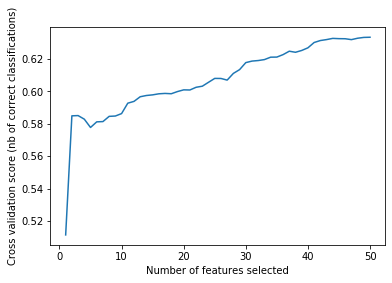

Optimal number of features : 50
The optimal features are:
['property_status', 'highest_education', 'time_at_employer', 'loan_purpose', 'time_at_current_address', 'state', 'bank', 'marital_status', 'employment_status', 'gender', 'device_brand', 'sector', 'application_time', 'application_week', 'income', 'time_at_property', 'num_applications', 'age', 'total_accounts', 'open_accounts_by_date', 'closed_accounts_by_date', 'performing_loans', 'paid_loans', 'nonperforming_loans', 'lost_loans', 'missed_payments', 'competitor_count', 'banking_count', 'news_count', 'gambling_count', 'vpn_count', 'app_count', 'device_price', 'max_balance', 'min_balance', 'credit_transactions', 'max_credit', 'min_credit', 'debit_transactions', 'max_debit', 'min_debit', 'insufficient_funds', 'succesful_payments', 'max_succesful_loan_payment', 'min_succesful_loan_payment', 'unsuccesful_payments', 'max_unsuccesful_loan_payment', 'min_unsuccesful_loan_payment', 'rejected_loans', 'max_loan_amount']
The omitted features

In [0]:
# feautre selection
mod = LinearSVC(random_state=0)
features, feautre_list = feature_selection(mod,X_train_res, y_train_res, [socio,credit,alt])
X_train_res = X_train_res[:,features]
X_test = X_test[:,features]

# All Models and Paramter Tuning

### Confusion Matrix Function

In [0]:
def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Model Performance Fucntion

In [0]:
classes = ['Repaid', 'Defaulted']

In [0]:
def Performance(Model,Y,X):
    target_names = ['Repaid', 'Defaulted']
    # Perforamnce of the model
    print("Accuracy")
    print(accuracy_score(Y,Model.predict(X).round()).round(4))
    print(" ")
    
    print ('Classification Report:')
    print(classification_report(Y,Model.predict(X).round()))
    print(" ")
    
    print('Confusion Matrix')
    cm = confusion_matrix(Y,Model.predict(X).round())
    plot_confusion_matrix(cm, classes, )
    
    fpr, tpr, _ = roc_curve(Y,Model.predict(X))
    AUC  = auc(fpr, tpr)
    print ('the AUC is : %0.4f' %  AUC)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % AUC)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

### Logistic Regression Model Training

In [0]:
lr_grid = {    
            "dual" : [True],
            "max_iter" : [500],
}

In [0]:
def build_lr_classifier(grid, cv, Y, X):
    lr=LogisticRegression()
    grid_search = GridSearchCV(lr, grid, n_jobs=-1, cv=cv, verbose=10,scoring='roc_auc')
    grid_search.fit(X, Y)
    return grid_search

In [0]:
lr_model = build_lr_classifier(lr_grid,5,y_train_res, X_train_res)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    5.6s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.6s finished


The best paramters
{'dual': True, 'max_iter': 500}
 
The training performance of the model
Accuracy
0.6297
 
Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      0.62      0.63     38392
         1.0       0.63      0.63      0.63     38392

    accuracy                           0.63     76784
   macro avg       0.63      0.63      0.63     76784
weighted avg       0.63      0.63      0.63     76784

 
Confusion Matrix


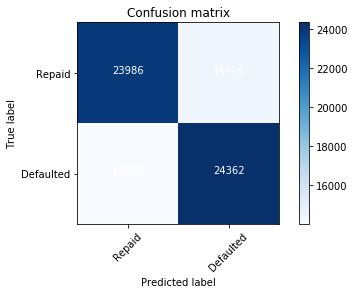

the AUC is : 0.6297


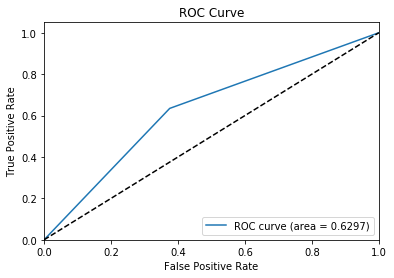

 
The testing performance of the model
Accuracy
0.6353
 
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.64      0.73      9568
         1.0       0.32      0.63      0.42      2567

    accuracy                           0.64     12135
   macro avg       0.59      0.63      0.58     12135
weighted avg       0.75      0.64      0.67     12135

 
Confusion Matrix


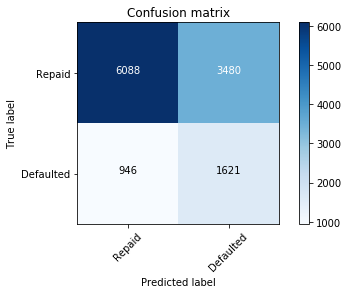

the AUC is : 0.6339


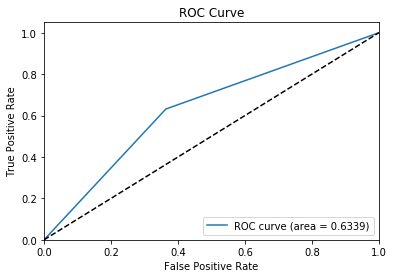

In [0]:
print("The best paramters")
print(lr_model.best_params_)
print(" ")
print("The training performance of the model")
Performance(Model=lr_model,Y=y_train_res,X=X_train_res)
print(" ")
print("The testing performance of the model")
Performance(Model=lr_model,Y=y_test,X=X_test)

### Random Forest Model Training

In [0]:
rf_grid = {    
            "n_estimators"      : [50,100,500],
            "max_features"      : [0.6,0.7,0.8],
            "max_depth"         : [10,20,50],
            "min_samples_split" : [0.1,0.15,0.2],
            "class_weight"      : [{1:1.35}],
            "oob_score"         : [True, False],
            "bootstrap"         : [True, False],
            "criterion"         : ["gini"]
}


In [0]:
def build_rf_classifier(grid, cv, Y, X):
    RF=RandomForestClassifier()
    grid_search = GridSearchCV(RF, grid, n_jobs=-1, cv=cv, verbose=10, scoring='roc_auc')
    grid_search.fit(X, Y)
    return grid_search

In [0]:
rf_model = build_rf_classifier(rf_grid,5,y_train_res,X_train_res)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  2.0min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min finished


The best paramters
{'bootstrap': True, 'class_weight': {1: 1.35}, 'criterion': 'gini', 'max_depth': 50, 'max_features': 0.8, 'min_samples_split': 0.1, 'n_estimators': 100, 'oob_score': True}
 
The training performance of the model
Accuracy
0.7964
 
Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.77      0.79     38392
         1.0       0.78      0.82      0.80     38392

    accuracy                           0.80     76784
   macro avg       0.80      0.80      0.80     76784
weighted avg       0.80      0.80      0.80     76784

 
Confusion Matrix


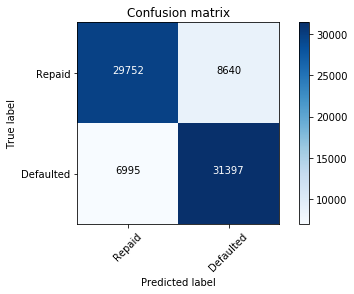

the AUC is : 0.7964


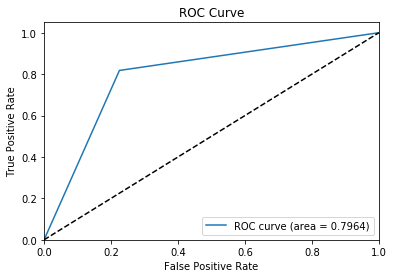

 
The testing performance of the model
Accuracy
0.7267
 
Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.78      0.82      9568
         1.0       0.39      0.52      0.45      2567

    accuracy                           0.73     12135
   macro avg       0.63      0.65      0.63     12135
weighted avg       0.76      0.73      0.74     12135

 
Confusion Matrix


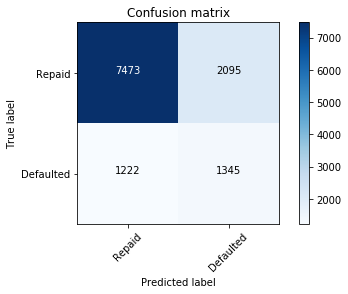

the AUC is : 0.6525


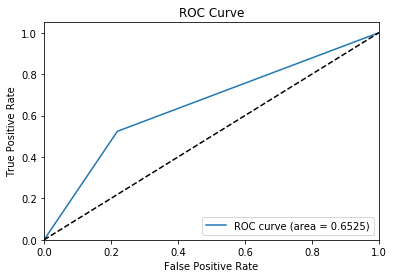

In [0]:
print("The best paramters")
print(rf_model.best_params_)
print(" ")
print("The training performance of the model")
Performance(Model=rf_model,Y=y_train_res,X=X_train_res)
print(" ")
print("The testing performance of the model")
Performance(Model=rf_model,Y=y_test,X=X_test)

### XGBoost Modeling

In [0]:
xgb_grid = params = {
                      "n_estimators"      : [50,100,500],
                      'min_child_weight'  : [1,5,10],
                      'gamma'             : [0.2,0.5,0.8],
                      'subsample'         : [0.6,0.7,0.8],
                      'colsample_bytree'  : [0.6,0.7,0.8],
                      'max_depth'         : [10,20,50],
                      "learning_rate"     : [0.015,0.03, 0.05],
                      "objective"         : ["binary:logistic"],
                      "eval_metric"       : ["auc"],
                      "scale_pos_weight"  : [1,1.5,2,2.5]
  }

In [0]:
def build_xgb_classifier(grid, cv, Y, X):
    xgb=XGBClassifier()
    grid_search = GridSearchCV(xgb, grid, n_jobs=-1, cv=cv, verbose=10, scoring='roc_auc')
    grid_search.fit(Y, X)
    return grid_search

In [0]:
xgb_model = build_xgb_classifier(xgb_grid,5,X_train_res,y_train_res)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.3min finished


The best paramters
{'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 100, 'objective': 'binary:logistic', 'scale_pos_weight': 3, 'subsample': 0.8}
 
The training performance of the model
Accuracy
0.9155
 
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.88      0.91     38392
         1.0       0.89      0.95      0.92     38392

    accuracy                           0.92     76784
   macro avg       0.92      0.92      0.92     76784
weighted avg       0.92      0.92      0.92     76784

 
Confusion Matrix


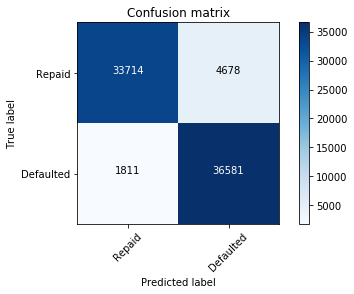

the AUC is : 0.9155


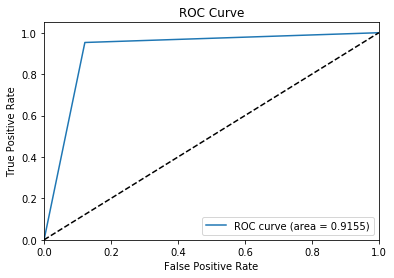

 
The testing performance of the model
Accuracy
0.8083
 
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.84      0.87      9568
         1.0       0.54      0.67      0.60      2567

    accuracy                           0.81     12135
   macro avg       0.72      0.76      0.74     12135
weighted avg       0.83      0.81      0.82     12135

 
Confusion Matrix


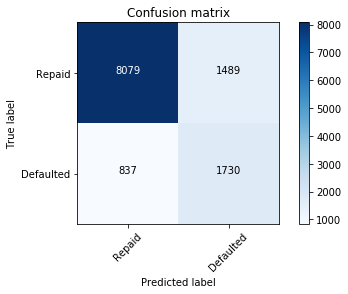

the AUC is : 0.7592


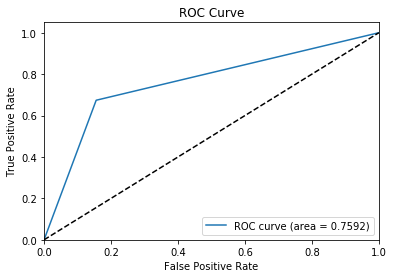

In [0]:
print("The best paramters")
print(xgb_model.best_params_)
print(" ")
print("The training performance of the model")
Performance(Model=xgb_model,Y=y_train_res,X=X_train_res)
print(" ")
print("The testing performance of the model")
Performance(Model=xgb_model,Y=y_test,X=np.array(X_test))

### Feature Importance for Best Performing XGBoost model

In [0]:
# mod = xgb.train({'colsample_bytree': 0.6, 'eta': 0.1, 'eval_metric': 'auc', 'gamma': 0.5, 'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 5, 'objective': 'binary:logistic', 'scale_pos_weight': 2.7, 'subsample': 0.5},
#               xgb.DMatrix(X_train_res, label=y_train_res),
#               100
# )
  
# explainer = shap.TreeExplainer(mod)
# shap_values = explainer.shap_values(X_train_res)
# shap.summary_plot(shap_values,features=X_train_res,feature_names=feautre_list,max_display=10)

### Neural Network 

In [0]:
nn_grid = {
            'learn_rate': [0.015, 0.03, 0.05],
            'epochs': [50,100,500],
            'batch_size': [2,5,10],
            'dropout_rate': [0.1,0.20.3],
            'neurons': [10,15,0],
            'activation': ['relu', 'sigmoid']
}

In [0]:
def nn_architecture(learn_rate=0.05,dropout_rate=0.15,neurons=10, activation='relu'):

    # create model
    model = Sequential()

    # add input layer
    model.add(Dense(neurons,
                    input_dim=X_train_res.shape[1],
                    activation=activation,
                    kernel_initializer='normal'
                    )
    )
    # add drop out rate
    model.add(Dropout(dropout_rate)
    )

    # add input layer
    model.add(Dense(5,
                    activation=activation,
                    kernel_initializer='normal'
                    )
    )
    # add drop out rate
    model.add(Dropout(dropout_rate)
    )

    # output layer
    model.add(Dense(1,
                    activation='sigmoid'
                    )
    )
    # compile model
    model.compile(optimizer=SGD(learn_rate),
                  loss='binary_crossentropy', 
                  metrics=['accuracy']
    )

    # fit model
    return model

In [0]:
def build_nn_classifier(grid, cv, Y, X):
  nn = KerasClassifier(build_fn=nn_architecture, verbose=2, batch_size=10, epochs=1000)
  nn = GridSearchCV(nn,grid,n_jobs=-1,cv=cv,verbose=10)
  grid_search.fit(X, Y)
  return nn

In [0]:
nn_model = build_nn_classifier(nn_grid,5,y_train_res, X_train_res)

Epoch 1/100
 - 9s - loss: 0.6899 - acc: 0.5252
Epoch 2/100
 - 9s - loss: 0.6766 - acc: 0.5744
Epoch 3/100
 - 9s - loss: 0.6707 - acc: 0.5841
Epoch 4/100
 - 9s - loss: 0.6663 - acc: 0.5914
Epoch 5/100
 - 9s - loss: 0.6632 - acc: 0.5937
Epoch 6/100
 - 9s - loss: 0.6612 - acc: 0.5972
Epoch 7/100
 - 9s - loss: 0.6594 - acc: 0.5992
Epoch 8/100
 - 9s - loss: 0.6577 - acc: 0.6017
Epoch 9/100
 - 9s - loss: 0.6568 - acc: 0.6045
Epoch 10/100
 - 9s - loss: 0.6558 - acc: 0.6070
Epoch 11/100
 - 9s - loss: 0.6538 - acc: 0.6100
Epoch 12/100
 - 9s - loss: 0.6522 - acc: 0.6103
Epoch 13/100
 - 9s - loss: 0.6522 - acc: 0.6137
Epoch 14/100
 - 9s - loss: 0.6508 - acc: 0.6162
Epoch 15/100
 - 9s - loss: 0.6492 - acc: 0.6152
Epoch 16/100
 - 9s - loss: 0.6491 - acc: 0.6183
Epoch 17/100
 - 9s - loss: 0.6469 - acc: 0.6208
Epoch 18/100
 - 9s - loss: 0.6461 - acc: 0.6219
Epoch 19/100
 - 9s - loss: 0.6455 - acc: 0.6231
Epoch 20/100
 - 9s - loss: 0.6441 - acc: 0.6251
Epoch 21/100
 - 9s - loss: 0.6433 - acc: 0.6265
E

 
The training performance of the model
Accuracy
0.6897
 
Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.58      0.65     38392
         1.0       0.65      0.80      0.72     38392

    accuracy                           0.69     76784
   macro avg       0.70      0.69      0.69     76784
weighted avg       0.70      0.69      0.69     76784

 
Confusion Matrix


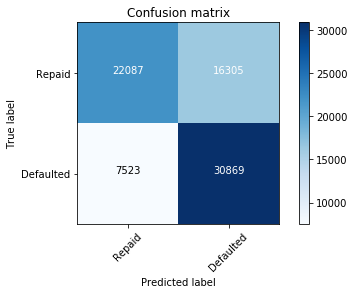

the AUC is : 0.6897


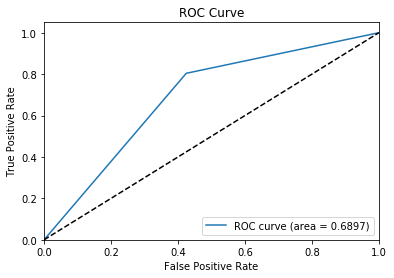

 
The testing performance of the model
Accuracy
0.6162
 
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.58      0.70      9568
         1.0       0.33      0.76      0.46      2567

    accuracy                           0.62     12135
   macro avg       0.61      0.67      0.58     12135
weighted avg       0.78      0.62      0.65     12135

 
Confusion Matrix


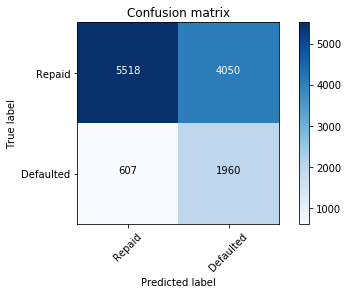

the AUC is : 0.6701


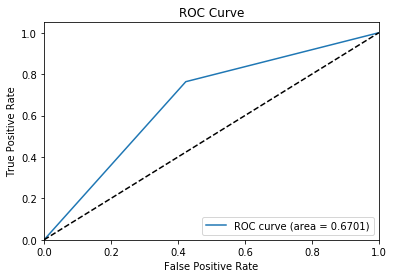

In [0]:
print("The best paramters")
print(nn_model.best_params_)
print(" ")
print("The training performance of the model")
Performance(Model=nn_model,Y=y_train_res,X=X_train_res)
print(" ")
print("The testing performance of the model")
Performance(Model=nn_model,Y=y_test,X=np.array(X_test))

# Mcnemar Function

In [0]:
def mcnemar_test(y, y_1, y_2):
  
  tb = mcnemar_table(y, 
                     y_1, 
                     y_2
                     )
  
  chi2, p = mcnemar(tb, exact=True, corrected=True)
  print('chi-squared:', chi2)
  print(" ")
  print('p-value:', p)

In [0]:
# lr vs nn
mcnemar_test(y_test,lr_model.predict(X_test).round(), nn_model.predict(X_test)[:, 0].round())

chi-squared: 1123
 
p-value: 3.755358124581476e-06


In [0]:
# rf vs nn
mcnemar_test(y_test,rf_model.predict(X_test).round(), nn_model.predict(X_test)[:, 0].round())

chi-squared: 1854
 
p-value: 3.710973736560783e-80


In [0]:
# xgb vs nn
mcnemar_test(y_test,xgb_model.predict(X_test).round(), nn_model.predict(X_test)[:, 0].round())

chi-squared: 754
 
p-value: 0.0


In [0]:
# lr vs rf
mcnemar_test(y_test,lr_model.predict(X_test).round(), rf_model.predict(X_test).round())

chi-squared: 1757
 
p-value: 2.873582223772211e-60


In [0]:
# lr vs xgb
mcnemar_test(y_test,lr_model.predict(X_test).round(), xgb_model.predict(X_test).round())

chi-squared: 662
 
p-value: 1.2766778436701685e-302


In [0]:
# rf vs xgb
mcnemar_test(y_test,rf_model.predict(X_test).round(), xgb_model.predict(X_test).round())

chi-squared: 903
 
p-value: 7.30196725232962e-80
